In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/')

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from utils import display_prediction
from gta5 import GTA5
from bisenetv2 import BiSeNetV2

In [3]:


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {DEVICE}')

NUM_CLASSES = 19    

BATCH_SIZE = 8       # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 10       # Total number of training epochs (iterations over dataset)
STEP_SIZE = 25        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1           # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 40

RESIZED_H = 512
RESIZED_W = 1024

MODE = 'TRAIN'       #TRAIN or LOAD_AND_TRAIN or LOAD
MODEL_PATH = '/content/drive/My Drive/gta5.tar' #File to save the model in

Running on cpu


In [4]:
mean = [0.3257, 0.3690, 0.3223]
std = [0.2112, 0.2148, 0.2115]

normalizer = transforms.Normalize(mean=mean, std=std)
resizer_bicubic = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.BICUBIC)
resizer_nearest = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.NEAREST)

train_transform = transforms.Compose([resizer_bicubic])
eval_transform = transforms.Compose([resizer_bicubic])
target_transform = transforms.Compose([resizer_nearest])


dataset = GTA5('drive/MyDrive/', transform=train_transform, target_transform=target_transform)


In [5]:
dataset

Dataset GTA5
    Number of datapoints: 500
    Root location: drive/MyDrive/
    StandardTransform
Transform: Compose(
               Resize(size=(512, 1024), interpolation=bicubic, max_size=None, antialias=None)
           )
Target transform: Compose(
                      Resize(size=(512, 1024), interpolation=nearest, max_size=None, antialias=None)
                  )

In [6]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']


class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [7]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [8]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

IndexError: ignored

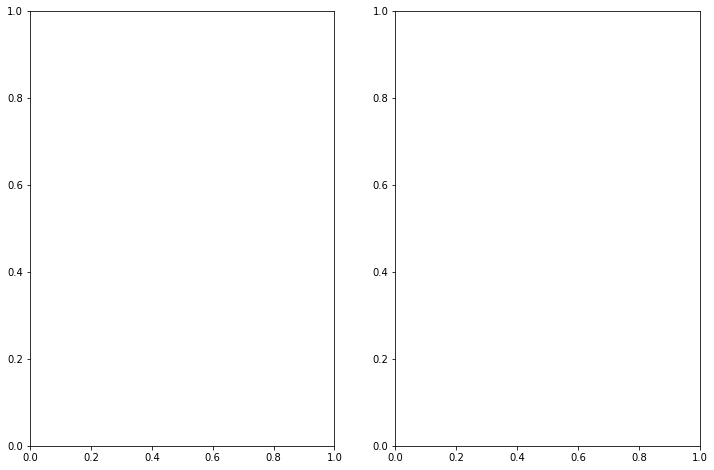

In [9]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
i = dataset[0][0].transpose(0,2).transpose(0,1)
l=dataset[0][1].transpose(0,2).transpose(0,1)
#l=encode_segmap(l)
ax[0].imshow(i)
ax[1].imshow(l)

In [10]:

from torch.utils.data import random_split

TRAIN_SIZE = 0.75
VAL_SIZE = 0.25

n_train = int(len(dataset)*TRAIN_SIZE)
n_val = len(dataset) - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])


In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:

print(len(train_dataset))
print(len(val_dataset))

print(len(train_dataloader))
print(len(val_dataloader))


img, lbl = train_dataset.__getitem__(1)
print(img.shape)
print(lbl.shape)



375
125
47
16
torch.Size([3, 512, 1024])
torch.Size([512, 1024])


shappesss torch.Size([3, 512, 1024]) torch.Size([512, 1024])


ValueError: ignored

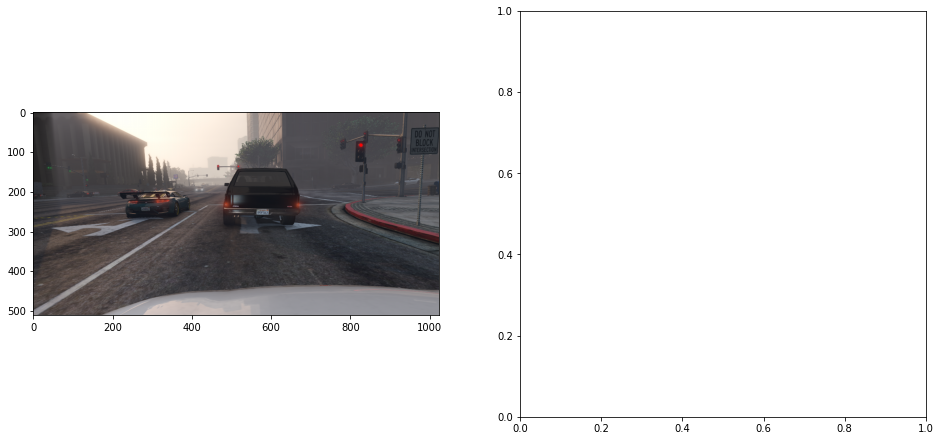

In [13]:
img, lbl = dataset[10]
print("shappesss", img.shape,lbl.shape)

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(lbl,cmap='rgb')


RuntimeError: ignored

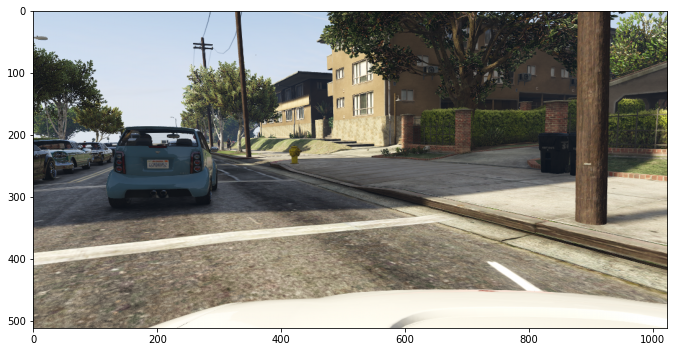

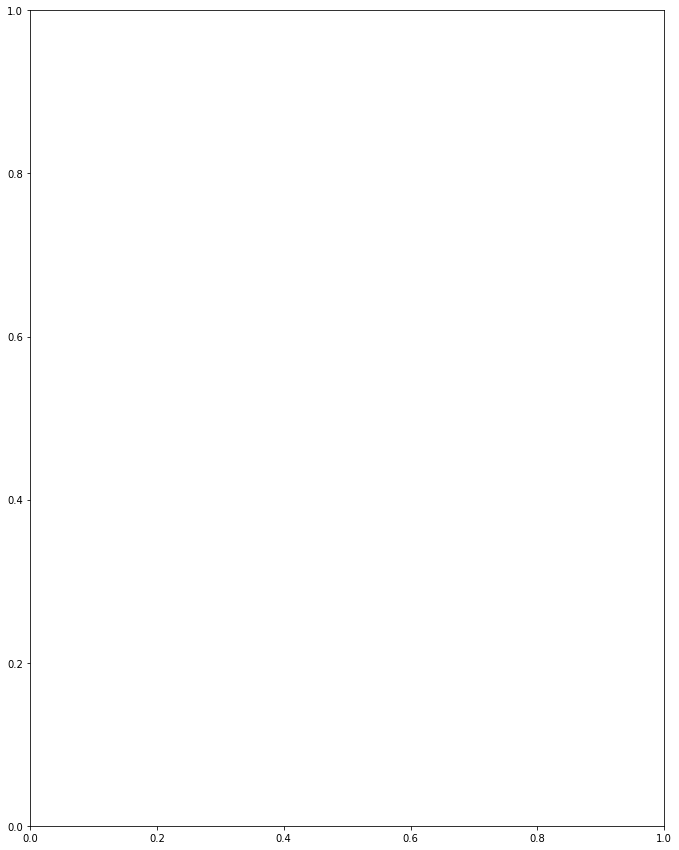

In [14]:
import random

# Get a random index from the dataset
idx = random.randint(0, len(train_dataset) - 1)

# Use the __getitem__ method to get the image and label
i, l = train_dataset.__getitem__(idx) #idx for random
fig = plt.figure(figsize=(25, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(i.permute(1, 2, 0))

fig = plt.figure(figsize=(25, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(l.permute(1, 2, 0))

In [16]:
net = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=False)
net = net.to(DEVICE)

In [20]:
!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=255).to(DEVICE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 15.8 MB/s eta 0:00:00


In [17]:
# Define loss function
criterion = nn.CrossEntropyLoss(ignore_index=255) # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of the net
# (nn.Module objects implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters

# Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [18]:
def train_epoch(net, dataloader, lr=0.01, optimizer=optimizer, loss_fn=criterion):
    net.train()

    total_loss, miou, count = 0, 0, 0
    for i, (images, masks) in enumerate(dataloader):
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.squeeze().to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()

        out = net(images)
        loss = loss_fn(out, masks) 
        loss.backward()
        optimizer.step()

        total_loss += loss
        miou += metric(out, masks)
        count += 1
        if i%LOG_FREQUENCY == 0:
            print("  minibatch {}: train mIoU = {} train loss = {}".format(i, miou.item()/count, total_loss.item()/count))
    return total_loss.item()/count, miou.item()/count

def validate(net, dataloader, loss_fn=criterion):
    net.eval()
    loss, miou, count = 0, 0, 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(DEVICE)
            masks = masks.squeeze().to(DEVICE)

            out = net(images)
            loss += loss_fn(out, masks) 
            miou += metric(out, masks)
            count += 1
    return loss.item()/count, miou.item()/count

def train(net, train_loader, test_loader, history=None, starting_epoch=0, optimizer=optimizer, lr=0.01, epochs=10, loss_fn=criterion):
    history = history or {'train_loss' : [0.0], 'train_miou': [0.0], 'val_loss': [0.0], 'val_miou': [0.0]} 

    print(f'Lr: {lr}\nBatch size: {BATCH_SIZE}\nEpochs: {epochs}\nLoss function: {loss_fn}\nOptimizer: {optimizer}')

    for ep in range(starting_epoch, starting_epoch + epochs):
        print(f'----------- EPOCH {ep+1} -----------')
        train_loss, train_miou = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        val_loss, val_miou = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Train mIoU={train_miou:.3f}, Val mIoU={val_miou:.3f}, Train loss={train_loss:.3f}, Val loss={val_loss:.3f}")
        
        save = False
        if val_miou > max(history['val_miou']): #If this is the best validation mIoU, save the model
            save = True
            print(f"MODEL SAVED WITH mIoU = {val_miou}") 

        history['train_loss'].append(train_loss)
        history['train_miou'].append(train_miou)
        history['val_loss'].append(val_loss)
        history['val_miou'].append(val_miou)
        display_prediction(net, val_dataset, random=False)
        scheduler.step()
                
        if save == True:
            torch.save({
                'model_state_dict': net.state_dict(),
                'optim_state_dict': optimizer.state_dict(),
                'epoch': ep,
                'history': history,
                'batch_size': BATCH_SIZE,
                'lr': lr,
                'resized_height': RESIZED_H,
                'resized_width': RESIZED_W,
            }, MODEL_PATH)

    return history

def plot_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(history['train_miou'], label='Training mIoU')
    plt.plot(history['val_miou'], label='Validation mIoU')
    plt.legend()
    plt.subplot(122)
    plt.plot(history['train_loss'], label='Training loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.legend()

In [21]:
def load_model(path):
    checkpoint = torch.load(MODEL_PATH)
    net.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optim_state_dict'])
    epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    return epoch, history

if MODE == 'LOAD':
    epoch, history = load_model(MODEL_PATH)
    net.eval()
    print(f'Loaded pre-trained model at epoch {epoch}')
    plot_history(history)
elif MODE == 'LOAD_AND_TRAIN':
    epoch, history = load_model(MODEL_PATH)
    print(f'Loaded pre-trained model at epoch {epoch}')
    plot_history(history)
    history = train(net, train_dataloader, val_dataloader, history, starting_epoch=epoch, optimizer=optimizer, lr=LR, epochs=NUM_EPOCHS)
    plot_history(history)
elif MODE == 'TRAIN':
    history = train(net, train_dataloader, val_dataloader, history=None, starting_epoch=0, optimizer=optimizer, lr=LR, epochs=NUM_EPOCHS)
    plot_history(history)

Lr: 0.05
Batch size: 8
Epochs: 10
Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.05
    lr: 0.05
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 5e-05
)
----------- EPOCH 1 -----------
  minibatch 0: train mIoU = 0.003338797017931938 train loss = 3.1767501831054688


KeyboardInterrupt: ignored